# Trump Tweet Predictions by Donald Weignberger
By Aleksa Basara (ab2295) and Roberto Halpin (rgh224) 

## Introduction

The Donald Trump twitter account has the discussion of many during his presidency. Prior to 2017, he used an Android phone. His staffers, on the other hand, used Iphones. Since both Trump and his staffers tweeted from the @realdonaldtrump twitter account, this allowed other twitter users to make a good guess as to who was tweeting based on what phone Twitter reported the tweet came from. In 2017, Trump switched over to an Iphone, essentially erasing that marked distinction. 

Fortunately for machine learning enthusiasts, there was still a rich dataset of essentially verified Trump vs Non-Trump tweets, prompting the challenge to predict whether future tweets came from Trump or his staffers based on the language, punctuation, and other features of the tweet.

In this project, Roberto and I tackle this challenge of extracting some neat features and predicting Trump using Logistic Regression and Random Forest.

## Library Import + Preliminary Data Exploration

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import re

from datetime import *

import seaborn as sns #Data viz library

import string
import random

from scipy import stats

#Import analysis libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics 
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

from nltk import TweetTokenizer


In [2]:
#Read dataset
data = pd.read_csv('C:/Documents/CS5780Final/train.csv')

In [3]:
#View dataset
data.head()

,id,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id.1,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,label
0,0,Senior United States District Judge Robert E. ...,False,14207,NaN,7/12/2016 0:56,False,NaN,7.530000e+17,NaN,"<a href=""http://twitter.com/download/iphone"" r...",realDonaldTrump,5256,False,False,NaN,NaN,-1
1,1,Speech on Veterans' Reform: https://t.co/XB7R...,False,9666,NaN,7/11/2016 22:18,False,NaN,7.530000e+17,NaN,"<a href=""http://twitter.com/download/iphone"" r...",realDonaldTrump,3432,False,False,NaN,NaN,-1
2,2,Great poll- Florida! Thank you! https://t.co/4...,False,25531,NaN,7/11/2016 21:40,False,NaN,7.530000e+17,NaN,"<a href=""http://twitter.com/download/iphone"" r...",realDonaldTrump,8810,False,False,NaN,NaN,-1
3,3,Thoughts and prayers with the victims; and the...,False,28850,NaN,7/11/2016 19:51,False,NaN,7.530000e+17,NaN,"<a href=""http://twitter.com/download/iphone"" r...",realDonaldTrump,9112,False,False,NaN,NaN,-1
4,4,Join me in Westfield; Indiana- tomorrow night ...,False,12567,NaN,7/11/2016 11:57,False,NaN,7.520000e+17,NaN,"<a href=""http://twitter.com/download/iphone"" r...",realDonaldTrump,4144,False,False,NaN,NaN,-1


In [4]:
#Explore dataset a bit
#mydata['text'][1]
type(data['created'][1])

str

In [5]:
data.describe()

,id,favoriteCount,replyToSID,id.1,replyToUID,retweetCount,longitude,latitude,label
count,1089.000000,1089.000000,0.0,1.089000e+03,3.000000e+00,1089.000000,2.000000,2.000000,1089.000000
mean,544.000000,15689.673095,NaN,7.229394e+17,1.468150e+08,5425.376492,-73.883040,40.773742,0.136823
std,314.511526,12401.107292,NaN,1.811442e+16,1.870245e+08,6464.072195,0.003203,0.005141,0.991051
min,0.000000,2304.000000,NaN,6.760000e+17,7.592510e+05,713.000000,-73.885305,40.770107,-1.000000
25%,272.000000,9248.000000,NaN,7.070000e+17,4.141904e+07,2889.000000,-73.884172,40.771924,-1.000000
50%,544.000000,13563.000000,NaN,7.240000e+17,8.207883e+07,4412.000000,-73.883040,40.773742,1.000000
75%,816.000000,19275.000000,NaN,7.380000e+17,2.198429e+08,6475.000000,-73.881907,40.775559,1.000000
max,1088.000000,291476.000000,NaN,7.530000e+17,3.576069e+08,169526.000000,-73.880775,40.777377,1.000000


In [6]:
#Subset data to include only features we may care about
mydata = data[['text','favoriteCount', 'created', 'retweetCount', 'label']]
mydata.head(10)

,text,favoriteCount,created,retweetCount,label
0,Senior United States District Judge Robert E. ...,14207,7/12/2016 0:56,5256,-1
1,Speech on Veterans' Reform: https://t.co/XB7R...,9666,7/11/2016 22:18,3432,-1
2,Great poll- Florida! Thank you! https://t.co/4...,25531,7/11/2016 21:40,8810,-1
3,Thoughts and prayers with the victims; and the...,28850,7/11/2016 19:51,9112,-1
4,Join me in Westfield; Indiana- tomorrow night ...,12567,7/11/2016 11:57,4144,-1
5,I heard that the underachieving John King of @...,22978,7/10/2016 18:58,6564,1
6,The media is so dishonest. If I make a stateme...,44600,7/10/2016 18:42,14520,1
7,President Obama thinks the nation is not as di...,35167,7/10/2016 18:27,11975,1
8,Look what is happening to our country under th...,55495,7/10/2016 12:02,19030,1
9,New poll - thank you! #Trump2016 https://t.co...,24040,7/9/2016 21:22,9147,-1


In [7]:
#Create columns of hour tweet was created, depending on whether it was trump or not
hourcolY = pd.to_datetime(mydata[mydata.label ==1].created)
hourcolN = pd.to_datetime(mydata[mydata.label ==-1].created)

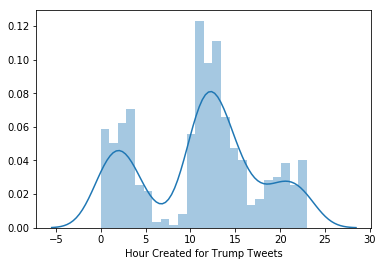

In [8]:
#Create histogram of hour of creation for Trump Tweets
sns.distplot(hourcolY.dt.hour, bins = 24, axlabel = "Hour Created for Trump Tweets")

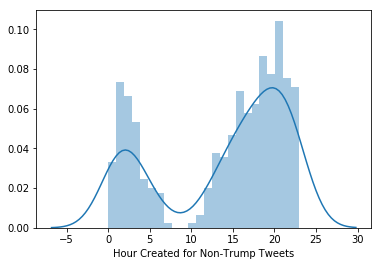

In [9]:
#Create histogram of hour of creation for Non-Trump Tweets
sns.distplot(hourcolN.dt.hour, bins = 24, axlabel = "Hour Created for Non-Trump Tweets")

In [10]:
#Find proportion of Trump Tweets
mydata[mydata.label == 1]['text'].count()/mydata['text'].count()

0.5684113865932048

# Begin NLP

## Define helper functions

In [11]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 3 columns indicating whether tweet was created in one of 3 time periods
def binned_time_of_day(df, col):
    df_new = df.copy()
    df_new['hour_0_8'] = np.where(((pd.to_datetime(df_new[col]).dt.hour >= 0) &
                                    (pd.to_datetime(df_new[col]).dt.hour < 8)),
                                    1, 0)
    df_new['hour_8_16'] = np.where(((pd.to_datetime(df_new[col]).dt.hour >= 8) &
                                    (pd.to_datetime(df_new[col]).dt.hour < 16)),
                                    1, 0)
    df_new['hour_16_0'] = np.where(((pd.to_datetime(df_new[col]).dt.hour >= 16) &
                                    (pd.to_datetime(df_new[col]).dt.hour < 24)),
                                    1, 0)
    return df_new


In [12]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 7 columns indicating whether tweet was created in one of 7 days of week
def day_of_week(df, col):
    day_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
                   'Thursday': 4, 'Friday': 5, 'Saturday': 6}
    df_new = df.copy()
    df_new['day_of_week'] = pd.to_datetime(df_new[col]).dt.weekday
    
    for w in day_dict.keys():
        fun = lambda d: 1 if d == day_dict[w] else 0
        df_new[w] = df_new['day_of_week'].apply(fun)
    
    return df_new


In [13]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 1 column giving tweet length
def tweet_length(df, col):
    df_new = df.copy()
    df_new['tweet_length'] = df_new[col].str.len()
    
    return df_new


In [14]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 1 column for each punctuation indicating # of times punctuation appears in tweet
def punctuation(df, col):
    punct_dict = {'commas': ',', 'semicolons': ';', 'exclamations': '!',
                  'periods': '\. ', 'questions': '\?', 'quotes': '"',
                  'dollars': '\$', 'percents': '%'}
    df_new = df.copy()
    for s in punct_dict.keys():
        df_new[s] = df_new[col].str.count(punct_dict.get(s))
        
    return df_new

#TO DO: Figure out why this doesn't work with: 'elipses': '...'

In [15]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 1 column indicating whether trump quoted someone else's tweet in his tweet
def quoted_retweet(df, col):
    fun = lambda s: 0 if re.match('^"@', s) is None else 1
    df_new = df.copy()
    df_new['quoted_rt'] = df_new[col].apply(fun)
    
    return df_new


In [16]:
#Input: dataframe (df) and text column (col)
#Output: New dataframe (df_new) 
#Purpose: Adds 1 column indicating how many ALL CAPS words were used
def all_caps(df, col):
    fun = lambda s: len(re.findall(r'\b[A-Z]{2,}\b', s))
    df_new = df.copy()
    df_new['all_caps'] = df_new[col].apply(fun)
    
    return df_new


In [17]:
def tweet_tokenize(df, col):
    gettokens = TweetTokenizer()
    fun = lambda s: ' '.join(gettokens.tokenize(s))
    df_new = df.copy()
    df_new['tokenized'] = df_new[col].apply(fun)
    
    return df_new


In [18]:
def mention_hashtag_url(df, col):
    df_new = tweet_tokenize(df, col)
    df_new['self_mentions'] = df_new['tokenized'].apply(lambda s: s.count('@realDonaldTrump'))
    df_new['mentions'] = df_new['tokenized'].apply(lambda s: len(re.findall(r'@\w+', s))) - df_new['self_mentions']
    df_new['hashtags'] = df_new['tokenized'].apply(lambda s: len(re.findall(r'#\w+', s)))
    df_new['urls'] = df_new['tokenized'].apply(lambda s: s.count('https'))
    
    return df_new


# Update dataset with new columns

In [19]:
#Add Time Periods
mydata = binned_time_of_day(mydata, 'created')

In [20]:
#Add Day of Week
mydata = day_of_week(mydata, 'created')

In [21]:
#Add Tweet length
mydata = tweet_length(mydata, 'text')

In [22]:
#Add Punctuation columns
mydata = punctuation(mydata, 'text')

In [23]:
#Add quoted retweet indicator column
mydata = quoted_retweet(mydata, 'text')

In [24]:
#Add quoted retweet indicator column
mydata = all_caps(mydata, 'text')

In [25]:
#Add self mentions, other mentions, hashtags, and URL columns
mydata = mention_hashtag_url(mydata, 'text')

In [26]:
mydata.columns

Index(['text', 'favoriteCount', 'created', 'retweetCount', 'label', 'hour_0_8',
       'hour_8_16', 'hour_16_0', 'day_of_week', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'tweet_length', 'commas',
       'semicolons', 'exclamations', 'periods', 'questions', 'quotes',
       'dollars', 'percents', 'quoted_rt', 'all_caps', 'tokenized',
       'self_mentions', 'mentions', 'hashtags', 'urls'],
      dtype='object')

In [67]:
#mydata[['label','day_of_week']].groupby(['label']).agg(['mean'])
mydata.head()

,text,favoriteCount,created,retweetCount,label,hour_0_8,hour_8_16,hour_16_0,day_of_week,Sunday,...,quotes,dollars,percents,quoted_rt,all_caps,tokenized,self_mentions,mentions,hashtags,urls
0,Senior United States District Judge Robert E. ...,14207,7/12/2016 0:56,5256,-1,1,0,0,1,0,...,0,0,0,0,0,Senior United States District Judge Robert E ....,0,0,0,1
1,Speech on Veterans' Reform: https://t.co/XB7R...,9666,7/11/2016 22:18,3432,-1,0,0,1,0,1,...,0,0,0,0,0,Speech on Veterans ' Reform : https://t.co/XB7...,0,0,0,1
2,Great poll- Florida! Thank you! https://t.co/4...,25531,7/11/2016 21:40,8810,-1,0,0,1,0,1,...,0,0,0,0,0,Great poll - Florida ! Thank you ! https://t.c...,0,0,0,1
3,Thoughts and prayers with the victims; and the...,28850,7/11/2016 19:51,9112,-1,0,0,1,0,1,...,0,0,0,0,0,Thoughts and prayers with the victims ; and th...,0,0,0,0
4,Join me in Westfield; Indiana- tomorrow night ...,12567,7/11/2016 11:57,4144,-1,0,1,0,0,1,...,0,0,0,0,0,Join me in Westfield ; Indiana - tomorrow nigh...,0,0,1,2


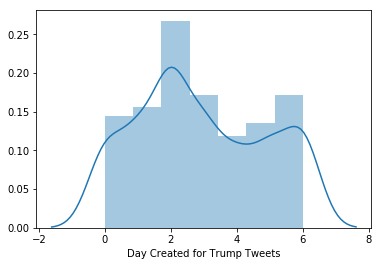

In [28]:
#Plot day of week for Trump
sns.distplot(mydata[mydata['label'] == 1]['day_of_week'], bins = 7, axlabel = "Day Created for Trump Tweets")

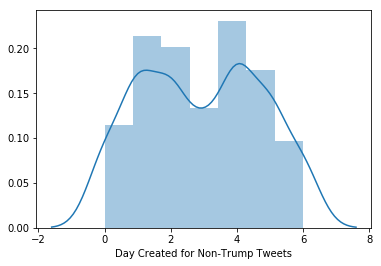

In [29]:
#Plot day of week for non Trump
sns.distplot(mydata[mydata['label'] == -1]['day_of_week'], bins = 7, axlabel = "Day Created for Non-Trump Tweets")

# Create Classifiers

### Create X and y for Training/Testing

In [30]:
#Create desired feature vector
my_features = ['hour_0_8', 'hour_8_16', 'hour_16_0', 'day_of_week', 'tweet_length', 'commas',
       'semicolons', 'exclamations', 'periods', 'questions', 'quotes',
       'dollars', 'percents', 'quoted_rt', 'all_caps', 'self_mentions', 'mentions', 'hashtags', 'urls', 'Sunday',
              'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

X = mydata[my_features]
y = mydata.label

In [32]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.10, random_state=1)

### Logistic Regression

In [33]:
#Run logistic regression
logreg1 = LogisticRegression()

logreg1.fit(X, y)

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
#Make make predictions
y_pred = logreg1.predict(X)

In [35]:
logreg_score = cross_val_score(logreg1, X, y, cv=10, scoring='accuracy')
logreg_score.mean()

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklea

0.8778287461773701

In [36]:
#confusion = metrics.confusion_matrix(y_test, y_pred)

In [37]:
#confusion

In [38]:
#accuracy = metrics.accuracy_score(y_test, y_pred)
#accuracy

### Random Forest

In [50]:
#Create choice of hyperparameters
depths = [20, 30, 50]
featNum = [5, 8, 10, 12]
treeNum = [50, 500, 1000]

In [51]:
rf_scores = []
for i in depths:
    for t in treeNum:
        rf = RandomForestClassifier(max_depth = i,
                                   max_features='sqrt',
                                    max_leaf_nodes=None,
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    n_estimators=t)
        scores = cross_val_score(rf, X, y, cv = 10, scoring = 'accuracy')
        rf_scores.append(scores.mean())
        print('The CV score for depths/trees, ', i, t, ' is ', scores.mean())

The CV score for depths/trees,  20 50  is  0.8961773700305811
The CV score for depths/trees,  20 500  is  0.8943510023785255
The CV score for depths/trees,  20 1000  is  0.8961773700305811
The CV score for depths/trees,  30 50  is  0.8971117906897723
The CV score for depths/trees,  30 500  is  0.8943510023785255
The CV score for depths/trees,  30 1000  is  0.8943510023785255
The CV score for depths/trees,  50 50  is  0.8989381583418282
The CV score for depths/trees,  50 500  is  0.89434250764526
The CV score for depths/trees,  50 1000  is  0.89434250764526


--> For Random Forest, just choose:
max_depth = 10
max_features = 'sqrt'
n_estimators = 100

In [56]:
#Train final Random Forest Model
rf1 = RandomForestClassifier(max_depth = 15,
                                   max_features='sqrt',
                                    max_leaf_nodes=None,
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    n_estimators=100)
rf1.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Prepare Classifiers for Submission

In [60]:
testdata0 = pd.read_csv('C:/Documents/CS5780Final/Given Test/test.csv')

In [61]:
#Add Time Periods
testdata = binned_time_of_day(testdata0, 'created')

#Add Day of Week
testdata = day_of_week(testdata, 'created')

#Add Tweet length
testdata = tweet_length(testdata, 'text')

#Add Tweet length
testdata = punctuation(testdata, 'text')

#Add Tweet length
testdata = quoted_retweet(testdata, 'text')

#Add Tweet length
testdata = all_caps(testdata, 'text')

#Add Tweet length
testdata = tweet_tokenize(testdata, 'text')

#Add Tweet length
testdata = mention_hashtag_url(testdata, 'text')

In [62]:
X_test_final = testdata[my_features]

In [55]:
#Make predictions on test set for Logistic Regression
log_test_pred = logreg1.predict(X_test_final)
#log_test_pred

In [63]:
#Make predictions on test set for Random Forest
rf_test_pred = rf1.predict(X_test_final)

In [64]:
testdata['Label'] = rf_test_pred
testdata['ID'] = testdata['id']
#testdata.rename({'id': 'ID'}, inplace=True)

### Check and Submit

In [65]:
testdata.head()

,id,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id.1,replyToUID,...,dollars,percents,quoted_rt,all_caps,tokenized,self_mentions,mentions,hashtags,urls,Label
0,0,My economic policy speech will be carried live...,False,9214,NaN,8/8/2016 15:20,False,NaN,7.630000e+17,NaN,...,0,0,0,0,My economic policy speech will be carried live...,0,0,0,0,1
1,1,Join me in Fayetteville; North Carolina tomorr...,False,6981,NaN,8/8/2016 13:28,False,NaN,7.630000e+17,NaN,...,0,0,0,0,Join me in Fayetteville ; North Carolina tomor...,0,0,0,1,-1
2,2,"#ICYMI: ""Will Media Apologize to Trump?"" https...",False,15724,NaN,8/8/2016 0:05,False,NaN,7.620000e+17,NaN,...,0,0,0,1,"#ICYMI : "" Will Media Apologize to Trump ? "" h...",0,0,1,1,-1
3,3,Michael Morell; the lightweight former Acting ...,False,19837,NaN,8/7/2016 23:09,False,NaN,7.620000e+17,NaN,...,0,0,0,0,Michael Morell ; the lightweight former Acting...,0,0,0,0,1
4,4,The media is going crazy. They totally distort...,False,34051,NaN,8/7/2016 21:31,False,NaN,7.620000e+17,NaN,...,0,0,0,0,The media is going crazy . They totally distor...,0,0,0,0,1


In [66]:
testdata.to_csv("C:/Documents/CS5780Final/test.csv", columns = ['ID','Label'], sep=",", header=True, index=False)

## Citations

### Packages

Sklearn: http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html
Pandas, Scipy: http://conference.scipy.org/proceedings/scipy2010/mckinney.html
Numpy: Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).
Seaborn: https://seaborn.pydata.org/
NLTK: https://www.nltk.org/

### Inspiration 

Greg Rafferty (Some feature extraction ideas): https://github.com/raffg/trump-tweet-author-identification/tree/master/src